In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [192]:
def direction_func(data_pt, final_dist_vec, scaler, direction, x1=0): 
    if direction == "negative": 
        x1 = x1 * -1
    margin = np.array([x1, x1]) 
    modified_pt = data_pt - final_dist_vec*scaler + margin
    return modified_pt

def J(x1, y1, x2, y2): 
    return (x2-x1)**2 + (y2-y1)**2

def displacement_func2(X_pred, Y_pred, datapt, margin=0): 
    X_pred = X_pred.flatten() 
    Y_pred = Y_pred.flatten()

    min_point_vector = (-1, -1)
    min_dist = float('inf')

    for k in range(len(X_pred)): 
        x, y = X_pred[k], Y_pred[k]

        dist = J(x,y, datapt[0], datapt[1])

        # Taking the absolute value since we only that value of orthogonality is as close to 0 as possible
        if min_dist > dist: 
            min_dist = dist 
            min_point_vector = (datapt[0] - x, datapt[1] - y)
    print(min_point_vector)
    return min_point_vector

# Uniqueness of orthogonal projection: https://math.stackexchange.com/questions/953997/uniqueness-of-orthogonal-projections 
# Minimum distance orthogonal projection: https://math.stackexchange.com/questions/2304079/show-orthogonal-projection-is-minimal-distance 
def displacement_func(X_pred, Y_pred, data_pt, margin=0): 
    #X_pred[1:-1], y_pred[1:-1]
    X_pred = X_pred.flatten() 
    Y_pred = Y_pred.flatten()

    min_point_vector = (-1, -1)
    min_orthogonal = 1

    for k in range(1, len(X_pred)-1): 
        dist_x, dist_y = X_pred[k] - X_pred[k-1], Y_pred[k] - Y_pred[k-1]
        point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]

        line_vector = np.array([dist_x, dist_y]).T 
        point_vector = np.array([point_dist_x, point_dist_y]) 

        # Taking the magnitudes of both vectors
        line_vector_m = np.linalg.norm(line_vector)
        point_vector_m = np.linalg.norm(point_vector)
        
        line_vector_norm = line_vector / line_vector_m
        point_vector_norm = point_vector / point_vector_m

        orthogonal = np.matmul(line_vector_norm, point_vector_norm)
        # Taking the absolute value since we only that value of orthogonality is as close to 0 as possible
        orthogonal = abs(orthogonal)
                
        if min_orthogonal > orthogonal: 
            min_orthogonal = orthogonal
            min_point_vector = point_vector

    # print(Z[0]) 
    # print(ZMOD[0])
    # print(ZREF[0]) 
    print(min_point_vector)
    return min_point_vector

In [193]:
from scipy.interpolate import interp1d

def boundary_generator(xx1, xx2, model, margin=0.005): 
    data = np.array([xx1.ravel(), xx2.ravel()]).T
    class_labels = model.predict(data).reshape(xx1.shape)
    boundary_df = pd.DataFrame([], columns=['x1', 'x2']) 

    for i in range(0, class_labels.shape[0]): 
        for j in range(1, class_labels.shape[1]): 
            if class_labels[i, j] != class_labels[i, j-1]: 
                result = smooth_op(model, np.array([xx1[i, j-1], xx2[i, j-1]]).reshape((1, data.shape[1])),   np.array([xx1[i,j], xx2[i,j]]).reshape((1, data.shape[1])))
                result = np.squeeze(result, axis=0)
                boundary_df.loc[len(boundary_df)] = result

    return boundary_df

def smooth_op(model, left, right):
    model_left = model.predict(left) 
    model_right = model.predict(right) 

    while model_left != model_right:  
        left = (left + right) / 2 
        model_left = model.predict(left) 
    
    return left 

def J(x1, y1, x2, y2): 
    return (x2-x1)**2 + (y2-y1)**2

def optimal_point(df, model, desired_class, undesired_coords, step_size=0.005, N=10000, margin=0.001,test=False, contours_val=False, diff_check=False): 

    # First feature
    X1=df['x1']

    # Second feature
    X2=df['x2']

    # Creating feature matrix from a set of two features
    X_train=np.array(list(zip(X1,X2)))

    # Getting labels of the features in the feature matrix
    y_train=df['y'].values

    model.fit(X_train, y_train)

    X = X_train
    x1_min, x1_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    x2_min, x2_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step=step_size),np.arange(x2_min, x2_max, step=step_size))

    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

    # Cubic interpolation 
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
    Y_pred = f(X_pred)

    if contours_val: 
        Z = model.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        contours = plt.contour(xx1, xx2, Z, levels=[-1, 0, 1])

        x_coords, y_coords = None, None
        i = 0 
        for collection in contours.collections:
            for path in collection.get_paths():
                if i == 1: 
                    vertices = path.vertices
                    x_coords = vertices[:, 0]
                    y_coords = vertices[:, 1]
                i+=1
        plt.plot(x_coords, y_coords, label='Decision Boundary')

    # plt.plot(bound_x, bound_y, 'o', label='Original Data')  # Original points
    plt.plot(X_pred, Y_pred)  # Interpolated curve
    #plt.plot(x_coords, y_coords, label='Decision Boundary')
    plt.xlabel('x')
    plt.ylabel('y')

    # Add a legend for the line plot
    plt.legend()

    if not test: 
        # Returns the minimum distance vector between the undesired coordinates and the decision boundary
        min_dist_vector = displacement_func(X_pred, Y_pred, undesired_coords)
    else: 
        min_dist_vector = displacement_func2(X_pred, Y_pred, undesired_coords)

    if desired_class: 
        undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)  
        optimal_datapt = direction_func(undesired_datapt, min_dist_vector, 1, 'negative', x1=margin)

        color_ls = []
        # Depending on labels assigns as 'b' or 'r' (blue or red) 
        for k in y_train:
            if k == 1:
                color_ls.append('b')
            else:
                color_ls.append('r')
        color_ls
        label = []
        for k in y_train:
            if k == 1:
                label.append('H')
            else:
                label.append('NH')
        label
        plt.scatter(undesired_datapt[0,0], undesired_datapt[0,1], c = 'r')
        plt.text(undesired_datapt[0,0]+0.002, undesired_datapt[0,1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0,0], optimal_datapt[0,1], c = 'b')
        plt.text(optimal_datapt[0,0]+0.002, optimal_datapt[0,1]+0.002, 'H')
        plt.plot([undesired_datapt[0,0], optimal_datapt[0,0]], [undesired_datapt[0,1],optimal_datapt[0,1]], linestyle='--')
        print(J(undesired_datapt[0,0],undesired_datapt[0,1], optimal_datapt[0,0], optimal_datapt[0,1]))
        # Display the plot
        return optimal_datapt 
    else: 
        reduction = 0.2 
        min_dist_vector = (1 - reduction) * min_dist_vector
        optimal_datapt = direction_func(undesired_coords, min_dist_vector, 1, 'negative', x1=margin)
        plt.scatter(undesired_datapt[0,0], undesired_datapt[0,1], c = 'r')
        plt.text(undesired_datapt[0,0]+0.002, undesired_datapt[0,1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0,0], optimal_datapt[0,1], c = 'b')
        plt.text(optimal_datapt[0,0]+0.002, optimal_datapt[0,1]+0.002, 'H')
        plt.plot([undesired_datapt[0,0], optimal_datapt[0,0]], [undesired_datapt[0,1],optimal_datapt[0,1]], linestyle='--')
        # Display the plot
        return optimal_datapt

[-0.47683706  3.38097071]
11.664146820430126


array([[13.47583706, 10.61802929]])

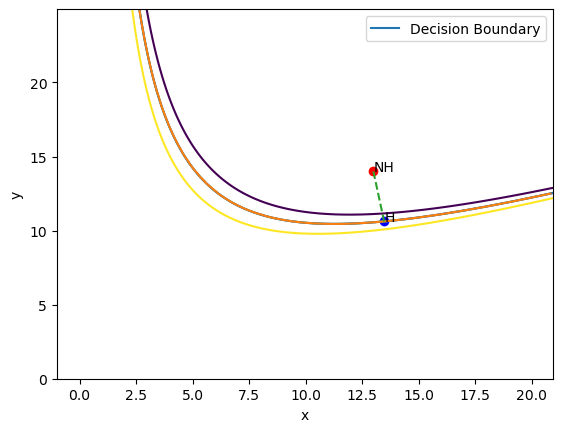

In [194]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(13,14), contours_val=True, diff_check=True, N=10000, step_size=0.05, test=False)
optimal_projection

(-0.4755086627887728, 3.3811576807838932)
11.66414904874707


array([[13.47450866, 10.61784232]])

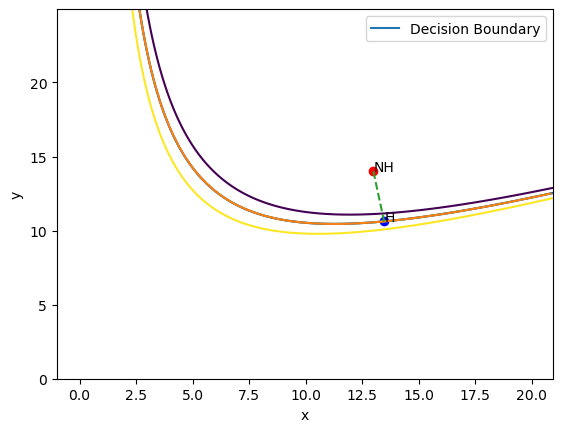

In [196]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(13,14), contours_val=True, diff_check=True, N=30000, step_size=0.05, test=True)
optimal_projection

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[3.57630763 0.5922934 ]
13.149126948589709


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[0.40296092 0.70537853]
0.6621550540700378


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[4.39925649 3.86064964]
34.27459507717113


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[3.94749944 4.36562782]
34.658086365050956


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[0.20472922 4.54087738]
20.6709746320346


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[-0.47683706  3.38097071]
11.664146820430126


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[-0.21726954  1.26321104]
1.645002068853966


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[-0.63446095  2.98025724]
9.289167497698383


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[-1.44948245  5.78602661]
35.58777833224989


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[-1.16990324  4.60129126]
22.547419659895443


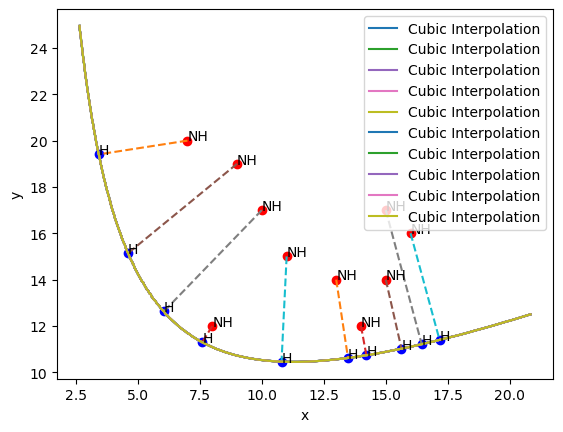

In [169]:
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])
# print(undesired_df)

optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  

    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=data_pt, contours_val=False, diff_check=False, N=10000, step_size=0.05, test=False)
    
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

In [170]:
optimal_datapts

,x1,x2
0,3.422692,19.406707
1,7.596039,11.293621
2,4.599744,15.138350
3,6.051501,12.633372
4,10.794271,10.458123
5,13.475837,10.618029
6,14.216270,10.735789
7,15.633461,11.018743
8,16.448482,11.212973
9,17.168903,11.397709


In [171]:
undesired_df

,x1,x2
0,7.0,20
1,8.0,12
2,9.0,19
3,10.0,17
4,11.0,15
5,13.0,14
6,14.0,12
7,15.0,14
8,15.0,17
9,16.0,16


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(3.5326457645764537, 0.8064274917751959)
13.138591543983495


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(0.40114167666765876, 0.7064145427572068)
0.6621532634174633


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(5.2179164791479105, 1.2203031802006272)
28.728670674289795


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(5.177308668366831, 2.344018537278725)
32.313992605063916


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(0.20472922292228013, 4.5408773782292275)
20.6709746320346


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(-0.47501781428144163, 3.3812267389073707)
11.66415060163614


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(-0.21726953945396055, 1.2632110405934363)
1.645002068853966


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(-0.6344609460946256, 2.9802572393993927)
9.289167497698383


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(-1.4494824482448436, 5.7860266052072475)
35.58777833224989


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

(-1.1699032403240501, 4.6012912635615955)
22.547419659895443


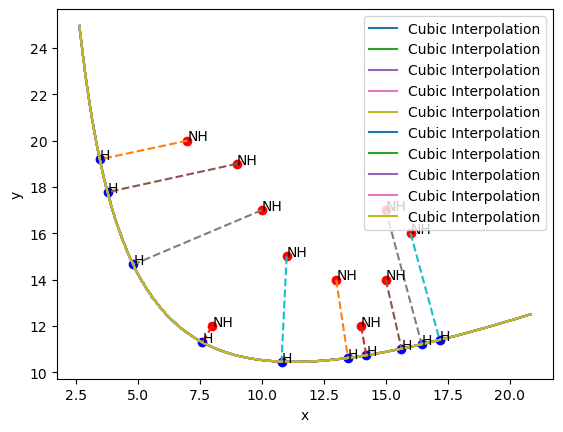

In [176]:
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])
# print(undesired_df)

optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  

    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=data_pt, contours_val=False, diff_check=False, N=10000, step_size=0.05, test=True)
    
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

In [177]:
optimal_datapts

,x1,x2
0,3.466354,19.192573
1,7.597858,11.292585
2,3.781084,17.778697
3,4.821691,14.654981
4,10.794271,10.458123
5,13.474018,10.617773
6,14.216270,10.735789
7,15.633461,11.018743
8,16.448482,11.212973
9,17.168903,11.397709


[-3.95167079  5.32757908]
44.00155466992466


array([[13.95067079, 11.67142092]])

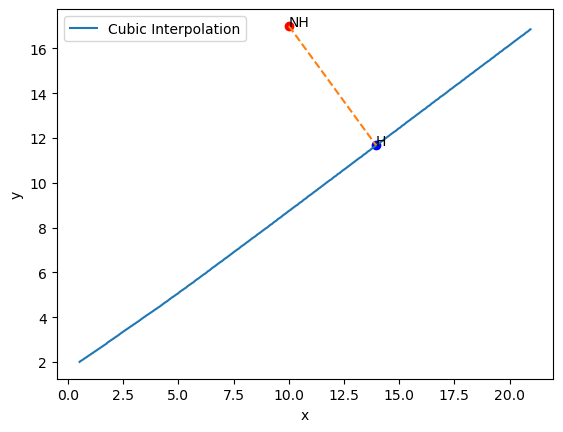

In [178]:
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1, max_iter=100000, hidden_layer_sizes=(100,25,25,1))
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']],df['y'], stratify=df['y'],
                                                    random_state=1)

optimal_point(df=pd.concat([X_train, y_train],axis=1), model=clf, desired_class=1, undesired_coords=(10,17), N=10000, step_size=0.05)

C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[2.57521221 4.54272032]
27.282263717031267


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[-0.54499075 -1.14000722]
1.5932633797950075


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[2.50311437 4.71195193]
28.48250471348051


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[1.94795042 3.58008817]
16.622600204923927


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[1.20520708 2.55976168]
8.012435918033644


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[1.30323939 2.62873228]
8.616532215482952


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

[0.84186512 1.43950796]
2.785484799227971
[2.25628469 3.21243678]


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

15.421510131677515
[2.92808062 5.84198518]
42.71998913820045


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  point_dist_x, point_dist_y = data_pt[0] - X_pred[k-1], data_pt[1] - Y_pred[k-1]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\2023845914.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)


[2.85713321 5.4310931 ]
37.67656086308364


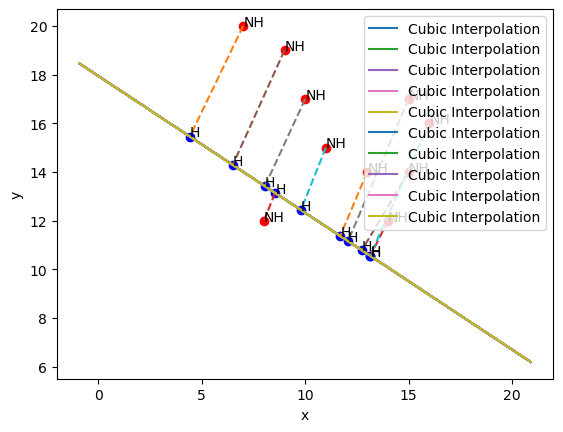

In [187]:
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))
test_set = pd.concat([X_test, y_test],axis=1)
for r in range(undesired_df.shape[0]):         
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df=pd.concat([X_train, y_train],axis=1), model=clf, desired_class=1, undesired_coords=data_pt, N=10000, step_size=0.05)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=100000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

(2.679976747674762, 4.496970701834758)
27.41937675613661


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(-0.5387451245124613, -1.1167972575907328)
1.5341733389839245


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(2.7308618361836112, 4.5964447863765425)
28.599567655777342


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(2.1327620262026112, 3.4951102854728564)
16.77572751265337


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(1.384227172717262, 2.487650259111506)
8.11223443221002


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(1.4351122612261111, 2.587170307888158)
8.761043969477852


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(0.6931180618061674, 1.5639625890544693)
2.930907788865616


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(2.0746562156215482, 3.350213938888098)
15.538983589646243


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(3.241072857285717, 5.690236311033157)
42.901207159971065


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(3.083377087708758, 5.34497035987631)
38.0927811078588


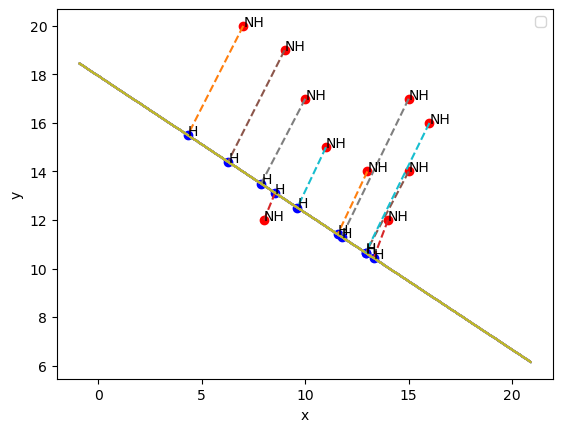

In [ ]:
undesired_df = df.loc[df['y'] == -1]
undesired_df = undesired_df.drop(columns=['y'])
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]):         
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df=df, model=clf, desired_class=1, undesired_coords=data_pt, N=10000, step_size=0.05, test=False)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

(2.679976747674762, 4.496970701834758)
27.41937675613661


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-0.5387451245124613, -1.1167972575907328)
1.5341733389839245


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(2.7308618361836112, 4.5964447863765425)
28.599567655777342


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(2.1327620262026112, 3.4951102854728564)
16.77572751265337
(1.384227172717262, 2.487650259111506)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)


8.11223443221002


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1.4351122612261111, 2.587170307888158)
8.761043969477852


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(0.6931180618061674, 1.5639625890544693)
2.930907788865616


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(2.0746562156215482, 3.350213938888098)
15.538983589646243


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(3.241072857285717, 5.690236311033157)
42.901207159971065


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\803852439.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_41904\953279874.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

(3.083377087708758, 5.34497035987631)
38.0927811078588


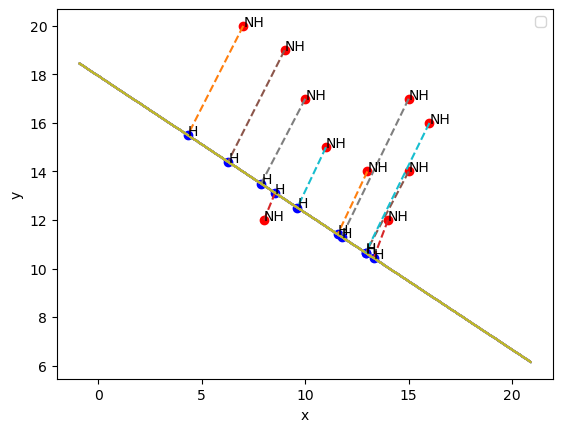

In [191]:
undesired_df = df.loc[df['y'] == -1]
undesired_df = undesired_df.drop(columns=['y'])
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]):         
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df=df, model=clf, desired_class=1, undesired_coords=data_pt, N=10000, step_size=0.05, test=True)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]